In [14]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import brentq, curve_fit, least_squares
from scipy.stats import norm

from math import log, exp, sqrt

In [15]:
# import excel data
df_discount = pd.read_csv('discount.csv')
df_call = pd.read_csv('goog_call.csv')
df_put = pd.read_csv('goog_put.csv')

# calculate time-to maturity
today = dt.date(2013, 8, 30)
expiry = dt.date(2015, 1, 17)
T = (expiry - today).days/365

# find risk-free rate by interpolation
r = np.interp(T * 365, df_discount['Day'], df_discount['Rate (%)']) / 100

# calculate forward price
S0 = 846.9
F = S0 * exp(r*T)

Here we filter out ITM options:

In [16]:
# filter out in-the money options and organise dataframes
# call 
df_call['mid_price'] = (df_call['best_bid'] + df_call['best_offer']) / 2
call = df_call[df_call['strike'] >= F]

# put 
df_put['mid_price'] = (df_put['best_bid'] + df_put['best_offer']) / 2
put = df_put[df_put['strike'] <= F]

# combine options
df_comb = pd.concat([put, call])
df_comb = df_comb.drop(['date', 'expiry', 'best_bid', 'best_offer'], axis=1)

In [17]:
### Create the columns for volatility
df_comb = df_comb.assign(vol_log=np.nan, vol_norm=np.nan, vol_market=np.nan, \
                         vol_dd=np.nan, vol_SABR=np.nan, \
                         vol_dd_beta02=np.nan,vol_dd_beta04=np.nan,\
                         vol_dd_beta06=np.nan, vol_dd_beta08=np.nan,\
                         vol_SABR_rho05=np.nan, vol_SABR_rho0=np.nan, vol_SABR_rho_05=np.nan,\
                         vol_SABR_nu01=np.nan, vol_SABR_nu04=np.nan, vol_SABR_nu07=np.nan)
#df_comb

## Market Volatility
We proceed to define a function using brentq solver to retrieve the implied vol from our given data. Also included are the Black76 lognormal, Bachelier (Black76 Normal) & Displaced Diffusion functions.

Recall that <b> Implied Volatility</b> is defined as <b>the value of $\sigma$ such that the Black Scholes Call option formula produces the same price as the observable option price.</b>  

In [18]:
# define Black76 Lognormal/Normal pricing functions
def Black76Lognormal(F, K, r, sigma, T, opt):
    d1 = (log(F/K)+(0.5*(sigma**2)*T))/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    if opt == 0:
        return exp(-r*T)*(F*norm.cdf(d1) - K*norm.cdf(d2))
    if opt == 1:
        return exp(-r*T)*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

# Bachelier
def Black76Normal(F, K, r, sigma, T, opt):
    x = (K-F)/(sigma*F*sqrt(T))
    if opt == 0:
        return exp(-r*T)*((F-K)*norm.cdf(-x)+sigma*sqrt(T)*F*norm.pdf(x))
    if opt == 1:
        return exp(-r*T)*((K-F)*norm.cdf(x)+sigma*sqrt(T)*F*norm.pdf(x))

# Displaced Diffusion also called Shifted Lognormal
def Displaced_Diffusion(F, K, beta, r, sigma, T, opt):
    Fd = F/beta
    Kd = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    d1 = (np.log(Fd/Kd) + (0.5*sigma_d**2)*T)/(sigma_d*np.sqrt(T))
    d2 = d1 - sigma_d*np.sqrt(T)
    
    if opt == 0: # call option
        call_value = Fd*np.exp(-r*T)*norm.cdf(d1) - Kd*np.exp(-r*T)*norm.cdf(d2)
        return call_value
    elif opt == 1: # put option
        put_value = -Fd*np.exp(-r*T)*norm.cdf(-d1) + Kd*np.exp(-r*T)*norm.cdf(-d2)
        return put_value

    
def impliedVolatility(price, K, opt):
    impliedVol = brentq(lambda x: price - \
                        Black76Lognormal(F, K, r, x, T, opt), 1e-6, 1)
    return impliedVol

## ATM Volatility
Here we implement the solver to find the at-the-money implied volatility

In [19]:
# find the at-the-money implied volatility using mid-price where strike is
# closest to forward price (K = 850)
ATMvol = (impliedVolatility(101.4, 850, 0)+impliedVolatility(102.9, 850, 1))/2
#ATMvol = 0.26

# calculate market, Black76 Lognormal and Black76 Normal implied volatilities, and Displaced-diffusion vol
for i in df_comb.index:
    K = df_comb.loc[i]['strike']
    if K >= F: # call
        opt = 0
    if K <= F:  # put
        opt = 1
    df_comb.loc[i]['vol_market'] \
    = impliedVolatility(df_comb.loc[i]['mid_price'], K, opt)
    df_comb.loc[i]['vol_norm'] \
    = impliedVolatility(Black76Normal(F, K, r, ATMvol, T, opt), K, opt)
    df_comb.loc[i]['vol_log'] \
    = impliedVolatility(Black76Lognormal(F, K, r, ATMvol, T, opt), K, opt)
    df_comb.loc[i]['vol_dd_beta02'] \
    = impliedVolatility(Displaced_Diffusion(F, K, 0.2, r, ATMvol, T, opt), K, opt)
    df_comb.loc[i]['vol_dd_beta04'] \
    = impliedVolatility(Displaced_Diffusion(F, K, 0.4, r, ATMvol, T, opt), K, opt)
    df_comb.loc[i]['vol_dd_beta06'] \
    = impliedVolatility(Displaced_Diffusion(F, K, 0.6, r, ATMvol, T, opt), K, opt)
    df_comb.loc[i]['vol_dd_beta08'] \
    = impliedVolatility(Displaced_Diffusion(F, K, 0.8, r, ATMvol, T, opt), K, opt)

df_comb.head()    

,strike,mid_price,vol_log,vol_norm,vol_market,vol_dd,vol_SABR,vol_dd_beta02,vol_dd_beta04,vol_dd_beta06,vol_dd_beta08,vol_SABR_rho05,vol_SABR_rho0,vol_SABR_rho_05,vol_SABR_nu01,vol_SABR_nu04,vol_SABR_nu07
0,320.0,1.450,0.258274,0.408859,0.393102,NaN,NaN,0.382252,0.354314,0.324730,0.293003,NaN,NaN,NaN,NaN,NaN,NaN
1,340.0,1.225,0.258274,0.398340,0.361520,NaN,NaN,0.373432,0.347321,0.319742,0.290289,NaN,NaN,NaN,NaN,NaN,NaN
2,350.0,1.625,0.258274,0.393369,0.365782,NaN,NaN,0.369270,0.344029,0.317402,0.289021,NaN,NaN,NaN,NaN,NaN,NaN
3,360.0,1.625,0.258274,0.388573,0.355104,NaN,NaN,0.365260,0.340861,0.315155,0.287808,NaN,NaN,NaN,NaN,NaN,NaN
4,370.0,1.750,0.258274,0.383942,0.348660,NaN,NaN,0.361392,0.337810,0.312995,0.286645,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
################# Calibration of Beta  #################################################
def Diffusioncalibration(beta1, strikes, vols, F, T):
    err = 0.0
    for i,vol in enumerate(vols):
        if strikes[i] >= F:
            opt = 1
        if strikes[i] <= F:
            opt = 0                     #price
        err +=(vol - impliedVolatility(Displaced_Diffusion(F, strikes[i], beta1, r, ATMvol, T, opt),
                                       strikes[i],
                                       opt))**2
    return err
    
beta_guess = [0.4]
res = least_squares(lambda beta: Diffusioncalibration(beta,
                                                      df_comb['strike'].values,
                                                      df_comb['vol_market'].values,
                                                      F, T), beta_guess)
Diff_beta = res.x[0]

for i in df_comb.index:
    K = df_comb.loc[i]['strike']
    if K >= F: # call
        opt = 0
    if K <= F:  # put
        opt = 1
    df_comb.loc[i]['vol_dd'] \
    = impliedVolatility(Displaced_Diffusion(F, K, Diff_beta, r, ATMvol, T, opt), K, opt)


In [9]:
SABRbeta = 0.5
# SABR model calibration
# copy sabr.py model function
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F is K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F*(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma


def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i,vol in enumerate(vols):
        
        err +=(vol - SABR(F, strikes[i],T,x[0],SABRbeta,x[1],x[2]))**2
    return err


In [10]:
############### Calibrated ALPHA, RHO, NU #########################################
#initial_guess = [α,ρ,ν]   
initial_guess = [0.02,0.2,0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_comb['strike'].values,
                                              df_comb['vol_market'].values,
                                              F,
                                              T), initial_guess)

alpha = res.x[0]
SABRbeta = 0.5
rho = res.x[1]
nu = res.x[2]
chg_rho = [-0.5,0,0.5]
chg_nu =[0.1,0.4,0.7]

################# Getting Implied Volatility ######################################
for i in df_comb.index:
    K = df_comb.loc[i]['strike']
    if K >= F:
        opt = 1
    if K <= F:
        opt = 0
    df_comb.loc[i]['vol_SABR'] \
    = impliedVolatility(\
                        Black76Lognormal(F, K, r, \
                                         SABR(F, K, T, alpha, SABRbeta, rho, nu), T, opt),\
                                K, opt)
    df_comb.loc[i]['vol_SABR_nu01'] \
    = impliedVolatility(\
                        Black76Lognormal(F, K, r, \
                                         SABR(F, K, T, alpha, SABRbeta, rho, chg_nu[0]), T, opt),\
                                K, opt)
    df_comb.loc[i]['vol_SABR_nu04'] \
    = impliedVolatility(\
                        Black76Lognormal(F, K, r, \
                                         SABR(F, K, T, alpha, SABRbeta, rho, chg_nu[1]), T, opt),\
                                K, opt)
    df_comb.loc[i]['vol_SABR_nu07'] \
    = impliedVolatility(\
                        Black76Lognormal(F, K, r, \
                                         SABR(F, K, T, alpha, SABRbeta, rho, chg_nu[2]), T, opt),\
                                K, opt)
    df_comb.loc[i]['vol_SABR_rho0'] \
    = impliedVolatility(\
                        Black76Lognormal(F, K, r, \
                                         SABR(F, K, T, alpha, SABRbeta, chg_rho[1], nu), T, opt),\
                                K, opt)
    df_comb.loc[i]['vol_SABR_rho05'] \
    = impliedVolatility(\
                        Black76Lognormal(F, K, r, \
                                         SABR(F, K, T, alpha, SABRbeta, chg_rho[2], nu), T, opt),\
                                K, opt)                      
    df_comb.loc[i]['vol_SABR_rho_05'] \
    = impliedVolatility(\
                        Black76Lognormal(F, K, r, \
                                         SABR(F, K, T, alpha, SABRbeta, chg_rho[0], nu), T, opt),\
                                K, opt)   


In [11]:
res

 active_mask: array([0., 0., 0.])
        cost: 1.1107258470920584e-06
         fun: array([0.00149045])
        grad: array([-5.53747948e-09,  1.16187723e-10,  8.11036719e-09])
         jac: array([[-3.71529833e-06,  7.79546099e-08,  5.44154318e-06]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 204
        njev: 201
  optimality: 8.110367185600305e-09
      status: 1
     success: True
           x: array([ 7.46839498, -0.04951923,  0.30576501])

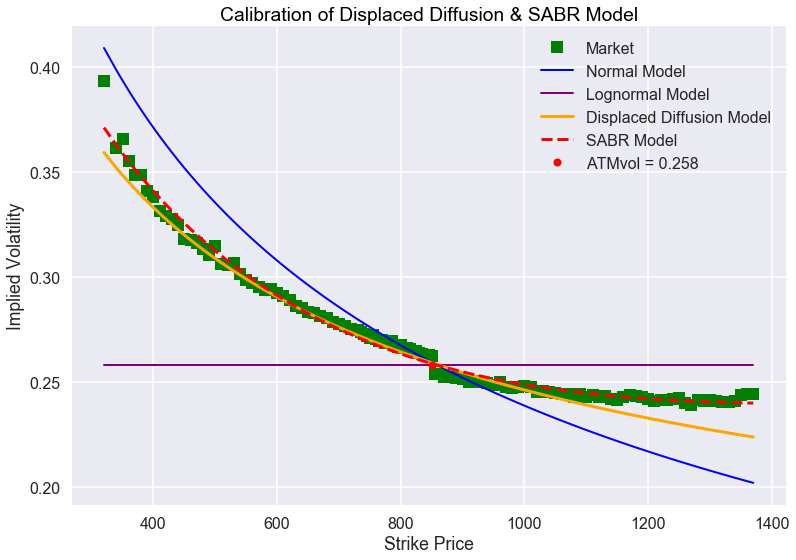

('-', '--', '-.', ':')

In [23]:
sns.set_context('poster')

############ Plot Calibrated displaced diffusion & SABR #######################################################
#plt.figure(figsize=(8 , 6))
plt.plot(df_comb['strike'],df_comb['vol_market'],'gs',label='Market')
plt.plot(df_comb['strike'],df_comb['vol_norm'],'b',linewidth=2,label='Normal Model')
plt.plot(df_comb['strike'],df_comb['vol_log'],'purple',linewidth=2,label='Lognormal Model')
# plot Displaced Diffusion
plt.plot(df_comb['strike'],df_comb['vol_dd'],'orange',linewidth=3, label='Displaced Diffusion Model')

# plot SABR 
plt.plot(df_comb['strike'],df_comb['vol_SABR'],'r--', linewidth=3,label='SABR Model')

#plot ATM volatility plt.text(gamma1[idx]-0.7,Ke_ratio[idx]+0.005, s = 'Min Gamma: %s' % np.round(gamma1[idx],3), fontsize=15 )

plt.plot(850, ATMvol, 'ro', markersize=8, label='ATMvol = 0.258')
plt.title('Calibration of Displaced Diffusion & SABR Model', color = 'k')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()
'-', '--', '-.', ':'


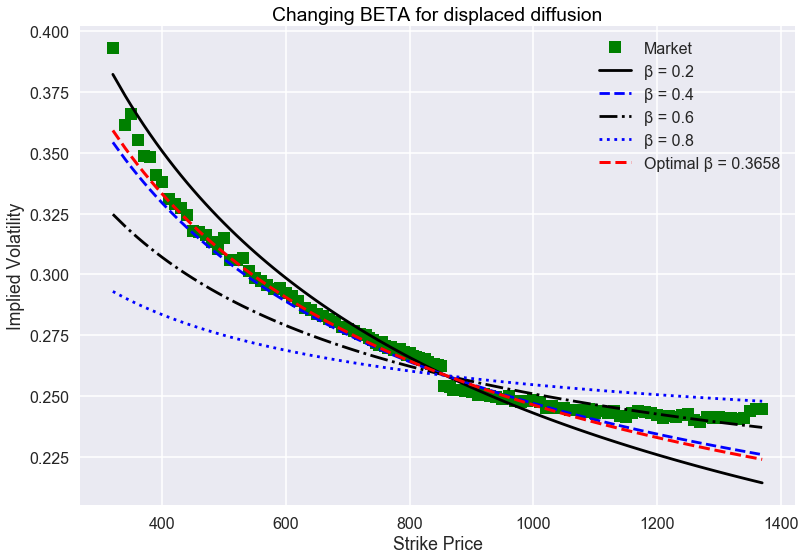

In [24]:
### Changing BETA############################################################################
#plt.figure(figsize=(8 , 6))
plt.plot(df_comb['strike'],df_comb['vol_market'],'gs',label='Market')
#plt.plot(df_comb['strike'],df_comb['vol_norm'],'b',label='Normal Model')
#plt.plot(df_comb['strike'],df_comb['vol_log'],'purple',label='Lognormal Model')
plt.plot(df_comb['strike'],df_comb['vol_dd_beta02'],'k-',label='β = 0.2')
plt.plot(df_comb['strike'],df_comb['vol_dd_beta04'],'b--',label='β = 0.4')
plt.plot(df_comb['strike'],df_comb['vol_dd_beta06'],'k-.',label='β = 0.6')
plt.plot(df_comb['strike'],df_comb['vol_dd_beta08'],'b:',label='β = 0.8')
plt.plot(df_comb['strike'],df_comb['vol_dd'],'r--',linewidth=3,label='Optimal β = %s' %round(Diff_beta,4))
plt.title('Changing BETA for displaced diffusion', color = 'k')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')

plt.legend()
plt.show()



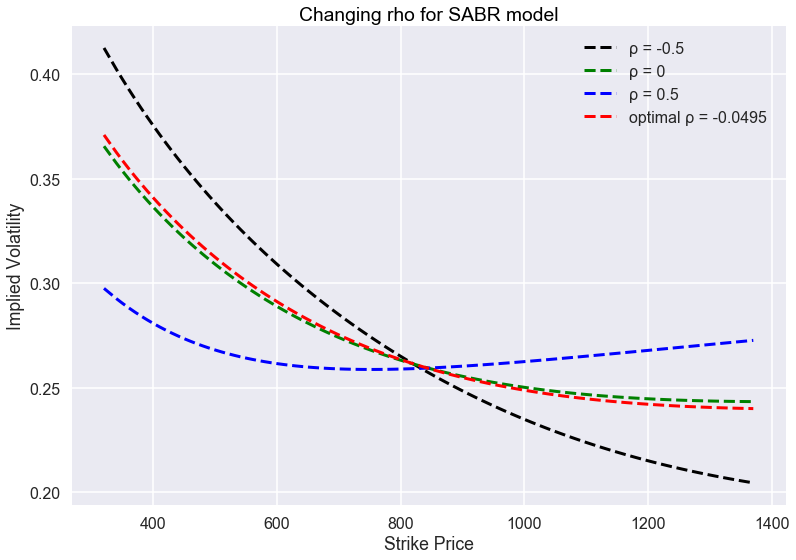

In [25]:
#########################################################################################
### Changing rho #######################################################################
#plt.figure(figsize=(8 , 6))
plt.plot(df_comb['strike'],df_comb['vol_SABR_rho_05'],'k--', linewidth=3,label='ρ = -0.5')
plt.plot(df_comb['strike'],df_comb['vol_SABR_rho0'],'g--', linewidth=3,label='ρ = 0')
plt.plot(df_comb['strike'],df_comb['vol_SABR_rho05'],'b--', linewidth=3,label='ρ = 0.5')
plt.plot(df_comb['strike'],df_comb['vol_SABR'],'r--', linewidth=3,label='optimal ρ = %s ' %round(rho,4))
plt.title('Changing rho for SABR model', color = 'k')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()



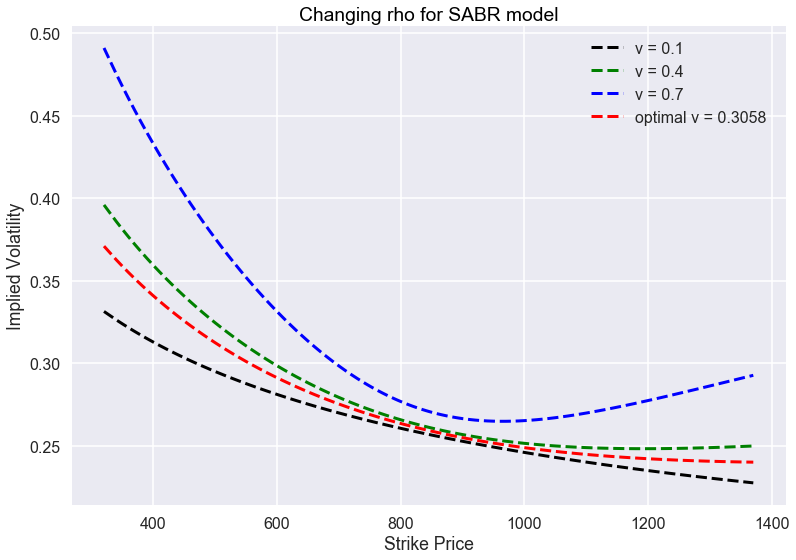

Model Parameters
1) σ: 0.25827414878228955, β: 0.365770400498
2) α: 7.46839491481 , ρ: -0.0495192091804 , ν: 0.305765037817


In [26]:
### Changing nu  ###################################################################################################
#plt.figure(figsize=(8 , 6))
plt.plot(df_comb['strike'],df_comb['vol_SABR_nu01'],'k--', linewidth=3,label='ν = 0.1')
plt.plot(df_comb['strike'],df_comb['vol_SABR_nu04'],'g--', linewidth=3,label='ν = 0.4')
plt.plot(df_comb['strike'],df_comb['vol_SABR_nu07'],'b--', linewidth=3,label='ν = 0.7')
plt.plot(df_comb['strike'],df_comb['vol_SABR'],'r--', linewidth=3,label='optimal ν = %s ' %round(nu,4))
plt.title('Changing nu for SABR model', color = 'k')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()


########################################################################################################################
########################################################################################################################
# report model parameters
print('Model Parameters')
print("1) σ: "+str(ATMvol)+", β: %s" %Diff_beta)
print("2) α: %s" %alpha, ", ρ: %s" %rho, ", ν: %s" %nu)